<a href="https://colab.research.google.com/github/saigirishgilly98/Major_Project/blob/main/WebScraping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install scrapy

     |████████████████████████████████| 245kB 2.8MB/s 
     |████████████████████████████████| 61kB 4.7MB/s 
     |████████████████████████████████| 2.6MB 9.7MB/s 
     |████████████████████████████████| 3.2MB 26.3MB/s 
     |████████████████████████████████| 245kB 34.2MB/s 
     |████████████████████████████████| 3.1MB 44.0MB/s 
     |████████████████████████████████| 61kB 4.1MB/s 
     |████████████████████████████████| 51kB 6.2MB/s 
  Created wheel for protego: filename=Protego-0.1.16-cp36-none-any.whl size=7765 sha256=e0efacc386fef950bbffb727e3cb79f73f6f9a3bc63c3de7bd09c1e8cc62a7f1
  Stored in directory: /root/.cache/pip/wheels/51/01/d1/4a2286a976dccd025ba679acacfe37320540df0f2283ecab12
  Created wheel for PyDispatcher: filename=PyDispatcher-2.0.5-cp36-none-any.whl size=11517 sha256=a70532fc9d0dd07a9ef1d53bf1718b046fa79ecdc4f13b7a604466bb0d2c069c
  Stored in directory: /root/.cache/pip/wheels/88/99/96/cfef6665f9cb1522ee6757ae5955feedf2fe25f1737f91fa7f
Successfully built protego PyD

In [ ]:
import scrapy
from scrapy.crawler import CrawlerProcess

In [ ]:
class DC_Chapter_Spider(scrapy.Spider):
  
  name = "dc_chapter_spider"

  def start_requests(self):
    url = 'https://www.datacamp.com/courses/all'
    yield scrapy.Request(url = url, callback = self.parse_front)

  def parse_front(self, response):
    # Narrow in on the course blocks
    course_blocks = response.css('div.course-block')

    # Direct to the course links
    course_links = course_blocks.xpath('./a/@href')

    # Extract the links (as a list of strings)
    links_to_follow = course_links.extract()

    # Follow the links to the next parser
    for url in links_to_follow:
      yield response.follow(url = url, callback = self.parse_pages)

  def parse_pages(self, response):
    
    # Direct to the course title text
    crs_title = response.xpath('//h1[contains(@class,"title")]/text()')
    
    # Extract and clean the course title text
    crs_title_ext = crs_title.extract_first().strip()
    
    # Direct to the chapter titles text
    ch_titles = response.css( 'h4.chapter__title::text' )
    
    # Extract and clean the chapter titles text
    ch_titles_ext = [t.strip() for t in ch_titles.extract()]
    
    # Store this in our dictionary
    dc_dict[ crs_title_ext ] = ch_titles_ext


dc_dict = dict()

process = CrawlerProcess()
process.crawl(DC_Chapter_Spider)
process.start()

In [ ]:
dc_dict

In [1]:
import pandas as pd
import csv

In [ ]:
class Payscale_Spider(scrapy.Spider):

  name = "payscale_spider"

  def start_requests(self):
    url = 'https://www.payscale.com/research/IN/Job/Information-Technology'
    yield scrapy.Request(url = url, callback = self.parse_jobs)

  def parse_jobs(self, response):

    job_blocks = response.css('div.subcats__links')
    job_links = job_blocks.xpath('./a/@href').extract()
    for link in job_links:
      yield response.follow(url = 'https://www.payscale.com' + link, callback = self.parse_salary)

  def parse_salary(self, response):

    # Extract the job
    job_title = response.url[41:len(response.url)-7]

    # Extract the average salary
    avg_salary = response.css('div.spotlight__value::text').extract_first()

    # Extract bonus, commission and profit sharing
    bonus_commision_profitsharing_value = response.css('div.spotlight__stat-value::text').extract()
    bonus_commision_profitsharing_label = response.css('div.spotlight__stat-label::text').extract()

    # Extract percentile of salary
    percentile_salary_ = response.css('div.percentile-chart__label')
    percentile_salary_name = percentile_salary_.xpath('./div[1]/text()').extract()
    percentile_salary_value = percentile_salary_.xpath('./div[2]/text()').extract()

    # Extract salary_distribution, company salaries and related job salaries
    salary_distribution_title = response.css('div.tablerow__title > a::text').extract()
    salary_distribution_value = response.css('div.tablerow__value::text').extract()

    # Extract career paths
    career_paths = response.xpath('//div[@class = "tree-chart__leaf_container"]/div[1]/text()').extract()

    # Extract popular skill and salaries
    skills_name = response.css('a.popular-skill__name::text').extract()
    skills_salaries = response.css('div.popular-skill__pay::text').extract()
    
    # Extract pay by experience
    pay_by_experience = response.css('div.job__blurb::text').extract()

    # Extract pay difference by location, experience affects salary, skills affect salary
    pay_by_location_name = response.css('div.entry > div.name > a::text').extract()
    pay_by_location_symbol = response.css('div.entry > div.arrow > span::attr(class)').extract()
    pay_by_location_percent = response.css('div.entry > div.arrow::text').extract()

    # Extract years of experience, gender breakdown
    experience_name = response.css('div.pie-chart__name::text').extract()
    experience_percent = response.css('div.pie-chart__value::text').extract() 

    # Extract health benefits
    health_benefits_name = response.css('div.health-benefits__item-name::text').extract()
    health_benefits_value = response.css('div.health-benefits__item-value::text').extract()

    # Updating all the values in the dictionary
    salary_dict['average_salary'] = avg_salary
    for label, value in zip(bonus_commision_profitsharing_label, bonus_commision_profitsharing_value):
      salary_dict[label] = value
    for label, value in zip(percentile_salary_name, percentile_salary_value):
      salary_dict[label] = value
    for label, value in zip(salary_distribution_title, salary_distribution_value[5:]):
      salary_dict[label] = value 
    salary_dict['career_paths'] = career_paths
    for label, value in zip(skills_name, skills_salaries):
      salary_dict[label + '_salary'] = value
    pay_by_experience_salary = list()
    for word in pay_by_experience[2].split():
      if word.startswith('₹'):
        pay_by_experience_salary.append(word)
    salary_dict['1yr'] = pay_by_experience_salary[0]
    salary_dict['1-4yrs'] = pay_by_experience_salary[1]
    salary_dict['5-9yrs'] = pay_by_experience_salary[2]
    salary_dict['10-19yrs'] = pay_by_experience_salary[3]
    salary_dict['20+yrs'] = pay_by_experience_salary[4]
    for label, symbol, value in zip(pay_by_location_name, pay_by_location_symbol, pay_by_location_percent):
      if symbol == 'negative':
        salary_dict[label + '_percent'] = '-' + value
      else:
        salary_dict[label + '_percent'] = value
    for label, value in zip(experience_name, experience_percent[::2]):
      salary_dict[label] = value
    for label, value in zip(health_benefits_name, health_benefits_value[::2]):
      salary_dict[label] = value
    salary_dict['Job Title'] = job_title

    # Storing the values in csv file
    df = pd.DataFrame(salary_dict)
    df.to_csv('' + job_title + '.csv')

salary_dict = dict()

process = CrawlerProcess()
process.crawl(Payscale_Spider)
process.start()

2020-10-16 15:09:57 [scrapy.utils.log] INFO: Scrapy 2.4.0 started (bot: scrapybot)
2020-10-16 15:09:57 [scrapy.utils.log] INFO: Versions: lxml 4.2.6.0, libxml2 2.9.8, cssselect 1.1.0, parsel 1.6.0, w3lib 1.22.0, Twisted 20.3.0, Python 3.6.9 (default, Jul 17 2020, 12:50:27) - [GCC 8.4.0], pyOpenSSL 19.1.0 (OpenSSL 1.1.1h  22 Sep 2020), cryptography 3.1.1, Platform Linux-4.19.112+-x86_64-with-Ubuntu-18.04-bionic
2020-10-16 15:09:57 [scrapy.utils.log] DEBUG: Using reactor: twisted.internet.epollreactor.EPollReactor
2020-10-16 15:09:57 [scrapy.crawler] INFO: Overridden settings:
{}
2020-10-16 15:09:57 [scrapy.extensions.telnet] INFO: Telnet Password: 694b012c46cfb37e
2020-10-16 15:09:57 [scrapy.middleware] INFO: Enabled extensions:
['scrapy.extensions.corestats.CoreStats',
 'scrapy.extensions.telnet.TelnetConsole',
 'scrapy.extensions.memusage.MemoryUsage',
 'scrapy.extensions.logstats.LogStats']
2020-10-16 15:09:57 [scrapy.middleware] INFO: Enabled downloader middlewares:
['scrapy.downloa

In [ ]:
salary_dict

{'.NET Software Developer / Programmer': '₹151k - ₹968k',
 '.NET_percent': '-8%',
 '.NET_salary': '₹803,979',
 '1-4yrs': '₹501,168',
 '10%': '₹261k',
 '10-19yrs': '₹1,507,035',
 '1yr': '₹394,619',
 '20+yrs': '₹813,892.',
 '3i Infotech Inc.': '₹158k',
 '5-9yrs': '₹886,543',
 '90%': '₹1m',
 'ABAP/4_salary': '₹511,531',
 'ASP.NET Framework_percent': '-11%',
 'ASP.NET Framework_salary': '₹412,972',
 'Accentcare, Inc.': '₹297k - ₹2m',
 'Accenture': '₹447k',
 'Accenture Technology Solutions': '₹455k',
 'Acceptance Testing_percent': '7%',
 'Accountant': '₹151k - ₹980k',
 'Adobe Photoshop_salary': '₹359,159',
 'Advanced Business Application Programming (ABAP) Language_salary': '₹485,059',
 'Agile Software Development_percent': '6%',
 'Agile Software Development_salary': '₹2,057,899',
 'Ahmedabad, Gujarat_percent': '-22%',
 'Algorithm Development_salary': '₹1,391,324',
 'Amadeus India Pvt Ltd': '₹2m',
 'Amazon Web Services (AWS)_percent': '-9%',
 'Amazon Web Services (AWS)_salary': '₹483,333',


In [ ]:
df2 = pd.read_csv('pay_scale.csv')
df2.head()

ParserError: ignored

# Mergining Data Files

Names of the files:


'Business_Analyst%2C_IT.csv'

'Data_Scientist.csv'

'Database_Administrator_(DBA).csv'

'Information_Technology_(IT)_Consultant.csv'

'Information_Technology_(IT)_Director.csv'

'Information_Technology_(IT)_Manager.csv'

'Information_Technology_Specialist.csv'

'Lead_Software_Engineer.csv'

'Network_Engineer.csv'

'Oracle_Database_Administrator_(DBA).csv'

'Product_Manager%2C_Software.csv'

'Project_Manager%2C_Information_Technology_(IT).csv'

'Project_Manager%2C_Software_Development.csv'

'Quality_Assurance_(QA)_Engineer.csv'

'SAP_Consultant.csv'

'Security_Consultant%2C_(Computing_%2F_Networking_%2F_Information_Technology).csv'

'Senior_Database_Administrator_(DBA).csv'

'Senior_Software_Engineer.csv'

'Senior_Systems_Analyst (1).csv'

'Senior_Systems_Analyst.csv'

'Senior_Systems_Engineer.csv'

'Senior_Technical_Consultant.csv'

'Software_Architect.csv'

'Software_Developer.csv'

'Software_Engineer.csv'

'Solutions_Architect.csv'

'Sr._Software_Engineer_%2F_Developer_%2F_Programmer.csv'

'Systems_Administrator.csv'

'Systems_Analyst.csv'

'Systems_Engineer_(Computer_Networking_%2F_IT).csv'

'Technical_Architect.csv'

'Technical_Consultant.csv'

'Technical_Project_Manager.csv'

'Technical_Support_Engineer.csv'

'Technical_Support_Specialist.csv'

In [8]:
df1 = pd.read_csv('Business_Analyst%2C_IT.csv')
df2= pd.read_csv('Data_Scientist.csv')
df3 = pd.read_csv('Database_Administrator_(DBA).csv')
df4 = pd.read_csv('Information_Technology_(IT)_Consultant.csv')
df5 = pd.read_csv('Information_Technology_(IT)_Director.csv')
df6 = pd.read_csv('Information_Technology_(IT)_Manager.csv')
df7 = pd.read_csv('Information_Technology_Specialist.csv')
df8 = pd.read_csv('Lead_Software_Engineer.csv')
df9 = pd.read_csv('Network_Engineer.csv')
df10 = pd.read_csv('Oracle_Database_Administrator_(DBA).csv')
df11 = pd.read_csv('Product_Manager%2C_Software.csv')
df12 = pd.read_csv('Project_Manager%2C_Information_Technology_(IT).csv')
df13 = pd.read_csv('Project_Manager%2C_Software_Development.csv')
df14 = pd.read_csv('Quality_Assurance_(QA)_Engineer.csv')
df15 = pd.read_csv('SAP_Consultant.csv')
df16 = pd.read_csv('Security_Consultant%2C_(Computing_%2F_Networking_%2F_Information_Technology).csv')
df17 = pd.read_csv('Senior_Database_Administrator_(DBA).csv')
df18 = pd.read_csv('Senior_Software_Engineer.csv')
df19 = pd.read_csv('Senior_Systems_Analyst (1).csv')
df20 = pd.read_csv('Senior_Systems_Analyst.csv')
df21 = pd.read_csv('Senior_Systems_Engineer.csv')
df22 = pd.read_csv('Senior_Technical_Consultant.csv')
df23 = pd.read_csv('Software_Architect.csv')
df24 = pd.read_csv('Software_Developer.csv')
df25 = pd.read_csv('Software_Engineer.csv')
df26 = pd.read_csv('Solutions_Architect.csv')
df27 = pd.read_csv('Sr._Software_Engineer_%2F_Developer_%2F_Programmer.csv')
df28 = pd.read_csv('Systems_Administrator.csv')
df29 = pd.read_csv('Systems_Analyst.csv')
df30 = pd.read_csv('Systems_Engineer_(Computer_Networking_%2F_IT).csv')
df31 = pd.read_csv('Technical_Architect.csv')
df32 = pd.read_csv('Technical_Consultant.csv')
df33 = pd.read_csv('Technical_Project_Manager.csv')
df34 = pd.read_csv('Technical_Support_Engineer.csv')
df35 = pd.read_csv('Technical_Support_Specialist.csv')

result = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10, df11, df12, df13, df14, df15, df16, df17, df18, df19, df20, df21, df22, df23, df24, df25, df26, df27, df28, df29, df30, df31, df32, df33, df34, df35], axis=0, ignore_index=True)

result

,Unnamed: 0,average_salary,Bonus,Profit Sharing,10%,MEDIAN,90%,IndiaNIC Infotech Ltd,Neosoft,Xento Systems,Software Engineer,Senior Software Engineer,Software Developer,Sr. Software Engineer / Developer / Programmer,Web Developer,Software Engineer / Developer / Programmer,"Team Leader, IT",Associate Software Engineer,.NET Software Developer / Programmer,career_paths,PHP_salary,MySQL_salary,JavaScript_salary,jQuery_salary,HTML5_salary,1yr,1-4yrs,5-9yrs,10-19yrs,Jio,Solution IT,Tata Consultancy Services Limited,Cognizant,Java Developer,Android Software Development Kit (SDK)_salary,Java_salary,Mobile applications development_salary,Android Operating System Development_salary,SQLite_salary,Accenture Technology Solutions,...,Quality Assurance / Quality Control_percent,Internal Audit_percent,Siemens,Systems Engineering_salary,Systems Engineering_percent,Flatworld Solutions,Globant,iOS_salary,Swift Programming Language_salary,Objective-C_salary,Apple Xcode IDE_salary,iOS SDK_salary,Enterprise Solutions_salary,System Architecture_salary,Enterprise Solutions_percent,Enterprise Application Integration_percent,System Architecture_percent,Pre-Sales_percent,Amazon Web Services (AWS)_percent,XYZ Corp.,Fiserv India Pvt Ltd,Directi,Senior SAP Consultant,SAP Materials Management (SAP MM)_salary,SAP Sales and Distribution (SAP SD)_salary,SAP Financial Accounting and Controlling (SAP FICO)_salary,SAP Business Intelligence (SAP BI)_percent,SAP Basis_percent,SAP Sales and Distribution (SAP SD)_percent,SAP ABAP_percent,SAP Human Resources (SAP HR)_percent,SAP Financial Accounting and Controlling (SAP FICO)_percent,SAP Enterprise Resource Planning (ERP)_percent,SAP Production Planning (SAP PP)_percent,SAP Security_percent,SAP Materials Management (SAP MM)_percent,Python_percent,Angular.js_percent,HTML_percent,PHP_percent
0,0,"₹607,210","₹51,209","₹25,000",₹276k,₹607k,₹1m,₹300k,₹350k,₹261k - ₹1m,₹261k - ₹1m,₹488k - ₹2m,₹211k - ₹1m,₹426k - ₹2m,₹124k - ₹777k,₹220k - ₹1m,₹584k - ₹2m,₹239k - ₹1m,₹193k - ₹1m,Senior Business Analyst,"₹277,333","₹287,251","₹1,468,581","₹277,924","₹453,521","₹353,752","₹519,244","₹841,360","₹1,209,704",₹282k,₹421k,₹684k,₹541k,₹239k - ₹1m,"₹389,971","₹878,496","₹387,213","₹384,633","₹353,442",₹721k,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,"₹607,210","₹51,209","₹25,000",₹276k,₹607k,₹1m,₹300k,₹350k,₹261k - ₹1m,₹261k - ₹1m,₹488k - ₹2m,₹211k - ₹1m,₹426k - ₹2m,₹124k - ₹777k,₹220k - ₹1m,₹584k - ₹2m,₹239k - ₹1m,₹193k - ₹1m,Lead Business Analyst,"₹277,333","₹287,251","₹1,468,581","₹277,924","₹453,521","₹353,752","₹519,244","₹841,360","₹1,209,704",₹282k,₹421k,₹684k,₹541k,₹239k - ₹1m,"₹389,971","₹878,496","₹387,213","₹384,633","₹353,442",₹721k,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,"₹607,210","₹51,209","₹25,000",₹276k,₹607k,₹1m,₹300k,₹350k,₹261k - ₹1m,₹261k - ₹1m,₹488k - ₹2m,₹211k - ₹1m,₹426k - ₹2m,₹124k - ₹777k,₹220k - ₹1m,₹584k - ₹2m,₹239k - ₹1m,₹193k - ₹1m,"Project Manager, (Unspecified Type / Gen...","₹277,333","₹287,251","₹1,468,581","₹277,924","₹453,521","₹353,752","₹519,244","₹841,360","₹1,209,704",₹282k,₹421k,₹684k,₹541k,₹239k - ₹1m,"₹389,971","₹878,496","₹387,213","₹384,633","₹353,442",₹721k,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,"₹813,769","₹100,205","₹47,896",₹343k,₹814k,₹2m,₹300k,₹350k,₹261k - ₹1m,₹261k - ₹1m,₹486k - ₹2m,₹211k - ₹1m,₹425k - ₹2m,₹198k - ₹1m,₹221k - ₹1m,₹220k - ₹1m,₹390k - ₹2m,₹193k - ₹1m,Senior Data Scientist,"₹277,333","₹287,251","₹1,468,581","₹277,924","₹453,521","₹520,351","₹771,852","₹1,372,216","₹1,827,036",₹282k,₹421k,₹891k,₹541k,₹239k - ₹1m,"₹389,971","₹1,580,600","₹387,213","₹384,633","₹353,442",₹1m,...,NaN,NaN,NaN,NaN,NaN

In [11]:
len(result.columns)

558

In [12]:
result.columns

Index(['Unnamed: 0', 'average_salary', 'Bonus', 'Profit Sharing', '10%',
       'MEDIAN', '90%', 'IndiaNIC Infotech Ltd', 'Neosoft', 'Xento Systems',
       ...
       'SAP Human Resources (SAP HR)_percent',
       'SAP Financial Accounting and Controlling (SAP FICO)_percent',
       'SAP Enterprise Resource Planning (ERP)_percent',
       'SAP Production Planning (SAP PP)_percent', 'SAP Security_percent',
       'SAP Materials Management (SAP MM)_percent', 'Python_percent',
       'Angular.js_percent', 'HTML_percent', 'PHP_percent'],
      dtype='object', length=558)

In [15]:
result = result[result['Unnamed: 0'] == 0]
result

,Unnamed: 0,average_salary,Bonus,Profit Sharing,10%,MEDIAN,90%,IndiaNIC Infotech Ltd,Neosoft,Xento Systems,Software Engineer,Senior Software Engineer,Software Developer,Sr. Software Engineer / Developer / Programmer,Web Developer,Software Engineer / Developer / Programmer,"Team Leader, IT",Associate Software Engineer,.NET Software Developer / Programmer,career_paths,PHP_salary,MySQL_salary,JavaScript_salary,jQuery_salary,HTML5_salary,1yr,1-4yrs,5-9yrs,10-19yrs,Jio,Solution IT,Tata Consultancy Services Limited,Cognizant,Java Developer,Android Software Development Kit (SDK)_salary,Java_salary,Mobile applications development_salary,Android Operating System Development_salary,SQLite_salary,Accenture Technology Solutions,...,Quality Assurance / Quality Control_percent,Internal Audit_percent,Siemens,Systems Engineering_salary,Systems Engineering_percent,Flatworld Solutions,Globant,iOS_salary,Swift Programming Language_salary,Objective-C_salary,Apple Xcode IDE_salary,iOS SDK_salary,Enterprise Solutions_salary,System Architecture_salary,Enterprise Solutions_percent,Enterprise Application Integration_percent,System Architecture_percent,Pre-Sales_percent,Amazon Web Services (AWS)_percent,XYZ Corp.,Fiserv India Pvt Ltd,Directi,Senior SAP Consultant,SAP Materials Management (SAP MM)_salary,SAP Sales and Distribution (SAP SD)_salary,SAP Financial Accounting and Controlling (SAP FICO)_salary,SAP Business Intelligence (SAP BI)_percent,SAP Basis_percent,SAP Sales and Distribution (SAP SD)_percent,SAP ABAP_percent,SAP Human Resources (SAP HR)_percent,SAP Financial Accounting and Controlling (SAP FICO)_percent,SAP Enterprise Resource Planning (ERP)_percent,SAP Production Planning (SAP PP)_percent,SAP Security_percent,SAP Materials Management (SAP MM)_percent,Python_percent,Angular.js_percent,HTML_percent,PHP_percent
0,0,"₹607,210","₹51,209","₹25,000",₹276k,₹607k,₹1m,₹300k,₹350k,₹261k - ₹1m,₹261k - ₹1m,₹488k - ₹2m,₹211k - ₹1m,₹426k - ₹2m,₹124k - ₹777k,₹220k - ₹1m,₹584k - ₹2m,₹239k - ₹1m,₹193k - ₹1m,Senior Business Analyst,"₹277,333","₹287,251","₹1,468,581","₹277,924","₹453,521","₹353,752","₹519,244","₹841,360","₹1,209,704",₹282k,₹421k,₹684k,₹541k,₹239k - ₹1m,"₹389,971","₹878,496","₹387,213","₹384,633","₹353,442",₹721k,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,"₹813,769","₹100,205","₹47,896",₹343k,₹814k,₹2m,₹300k,₹350k,₹261k - ₹1m,₹261k - ₹1m,₹486k - ₹2m,₹211k - ₹1m,₹425k - ₹2m,₹198k - ₹1m,₹221k - ₹1m,₹220k - ₹1m,₹390k - ₹2m,₹193k - ₹1m,Senior Data Scientist,"₹277,333","₹287,251","₹1,468,581","₹277,924","₹453,521","₹520,351","₹771,852","₹1,372,216","₹1,827,036",₹282k,₹421k,₹891k,₹541k,₹239k - ₹1m,"₹389,971","₹1,580,600","₹387,213","₹384,633","₹353,442",₹1m,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0,"₹495,452","₹45,615","₹20,645",₹240k,₹495k,₹1m,₹300k,₹350k,₹261k - ₹1m,₹486k - ₹2m,₹211k - ₹1m,₹425k - ₹2m,₹200k - ₹947k,₹586k - ₹2m,₹196k - ₹623k,₹238k - ₹1m,₹297k - ₹2m,₹124k - ₹776k,Senior Database Administrator (DBA),"₹516,552","₹476,805","₹827,832","₹435,524","₹372,430","₹296,395","₹414,474","₹851,518","₹1,267,886",₹787k,₹421k,₹800k,₹2m,₹776k - ₹3m,"₹389,971","₹1,325,597","₹387,213","₹384,633","₹353,442",₹443k,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0,"₹900,034","₹92,157","₹50,956",₹390k,₹900k,₹2m,₹300k,₹350k,₹261k - ₹1m,₹261k - ₹1m,₹488k - ₹2m,₹211k - ₹1m,₹426k - ₹2m,₹124k - ₹777k,₹220k - ₹1m,₹583k - ₹2m,₹239k - ₹1m,₹151k - ₹968k,Senior Technical Consultant,"₹265,348","₹476,805","₹466,486","₹435,524","₹307,247","₹358,978","₹616,801","₹987,124","₹1,440,890",₹787k,₹421k,₹1m,₹348k,₹198k - ₹1m,"₹389,971","₹815,633","₹387,213","₹384,633","₹353,442",₹577k,...,-6%,-18%,₹896k,"₹574,14

In [16]:
result['Job Title']

0                                 Business_Analyst%2C_IT
3                                         Data_Scientist
6                           Database_Administrator_(DBA)
9                 Information_Technology_(IT)_Consultant
12                  Information_Technology_(IT)_Director
15                   Information_Technology_(IT)_Manager
18                     Information_Technology_Specialist
21                                Lead_Software_Engineer
24                                      Network_Engineer
27                   Oracle_Database_Administrator_(DBA)
30                           Product_Manager%2C_Software
33        Project_Manager%2C_Information_Technology_(IT)
36               Project_Manager%2C_Software_Development
39                       Quality_Assurance_(QA)_Engineer
42                                        SAP_Consultant
45     Security_Consultant%2C_(Computing_%2F_Networki...
48                   Senior_Database_Administrator_(DBA)
51                             

In [17]:
result.to_csv('Payscale_final.csv')

In [18]:
result.head()

,Unnamed: 0,average_salary,Bonus,Profit Sharing,10%,MEDIAN,90%,IndiaNIC Infotech Ltd,Neosoft,Xento Systems,Software Engineer,Senior Software Engineer,Software Developer,Sr. Software Engineer / Developer / Programmer,Web Developer,Software Engineer / Developer / Programmer,"Team Leader, IT",Associate Software Engineer,.NET Software Developer / Programmer,career_paths,PHP_salary,MySQL_salary,JavaScript_salary,jQuery_salary,HTML5_salary,1yr,1-4yrs,5-9yrs,10-19yrs,Jio,Solution IT,Tata Consultancy Services Limited,Cognizant,Java Developer,Android Software Development Kit (SDK)_salary,Java_salary,Mobile applications development_salary,Android Operating System Development_salary,SQLite_salary,Accenture Technology Solutions,...,Quality Assurance / Quality Control_percent,Internal Audit_percent,Siemens,Systems Engineering_salary,Systems Engineering_percent,Flatworld Solutions,Globant,iOS_salary,Swift Programming Language_salary,Objective-C_salary,Apple Xcode IDE_salary,iOS SDK_salary,Enterprise Solutions_salary,System Architecture_salary,Enterprise Solutions_percent,Enterprise Application Integration_percent,System Architecture_percent,Pre-Sales_percent,Amazon Web Services (AWS)_percent,XYZ Corp.,Fiserv India Pvt Ltd,Directi,Senior SAP Consultant,SAP Materials Management (SAP MM)_salary,SAP Sales and Distribution (SAP SD)_salary,SAP Financial Accounting and Controlling (SAP FICO)_salary,SAP Business Intelligence (SAP BI)_percent,SAP Basis_percent,SAP Sales and Distribution (SAP SD)_percent,SAP ABAP_percent,SAP Human Resources (SAP HR)_percent,SAP Financial Accounting and Controlling (SAP FICO)_percent,SAP Enterprise Resource Planning (ERP)_percent,SAP Production Planning (SAP PP)_percent,SAP Security_percent,SAP Materials Management (SAP MM)_percent,Python_percent,Angular.js_percent,HTML_percent,PHP_percent
0,0,"₹607,210","₹51,209","₹25,000",₹276k,₹607k,₹1m,₹300k,₹350k,₹261k - ₹1m,₹261k - ₹1m,₹488k - ₹2m,₹211k - ₹1m,₹426k - ₹2m,₹124k - ₹777k,₹220k - ₹1m,₹584k - ₹2m,₹239k - ₹1m,₹193k - ₹1m,Senior Business Analyst,"₹277,333","₹287,251","₹1,468,581","₹277,924","₹453,521","₹353,752","₹519,244","₹841,360","₹1,209,704",₹282k,₹421k,₹684k,₹541k,₹239k - ₹1m,"₹389,971","₹878,496","₹387,213","₹384,633","₹353,442",₹721k,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0,"₹813,769","₹100,205","₹47,896",₹343k,₹814k,₹2m,₹300k,₹350k,₹261k - ₹1m,₹261k - ₹1m,₹486k - ₹2m,₹211k - ₹1m,₹425k - ₹2m,₹198k - ₹1m,₹221k - ₹1m,₹220k - ₹1m,₹390k - ₹2m,₹193k - ₹1m,Senior Data Scientist,"₹277,333","₹287,251","₹1,468,581","₹277,924","₹453,521","₹520,351","₹771,852","₹1,372,216","₹1,827,036",₹282k,₹421k,₹891k,₹541k,₹239k - ₹1m,"₹389,971","₹1,580,600","₹387,213","₹384,633","₹353,442",₹1m,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,0,"₹495,452","₹45,615","₹20,645",₹240k,₹495k,₹1m,₹300k,₹350k,₹261k - ₹1m,₹486k - ₹2m,₹211k - ₹1m,₹425k - ₹2m,₹200k - ₹947k,₹586k - ₹2m,₹196k - ₹623k,₹238k - ₹1m,₹297k - ₹2m,₹124k - ₹776k,Senior Database Administrator (DBA),"₹516,552","₹476,805","₹827,832","₹435,524","₹372,430","₹296,395","₹414,474","₹851,518","₹1,267,886",₹787k,₹421k,₹800k,₹2m,₹776k - ₹3m,"₹389,971","₹1,325,597","₹387,213","₹384,633","₹353,442",₹443k,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0,"₹900,034","₹92,157","₹50,956",₹390k,₹900k,₹2m,₹300k,₹350k,₹261k - ₹1m,₹261k - ₹1m,₹488k - ₹2m,₹211k - ₹1m,₹426k - ₹2m,₹124k - ₹777k,₹220k - ₹1m,₹583k - ₹2m,₹239k - ₹1m,₹151k - ₹968k,Senior Technical Consultant,"₹265,348","₹476,805","₹466,486","₹435,524","₹307,247","₹358,978","₹616,801","₹987,124","₹1,440,890",₹787k,₹421k,₹1m,₹348k,₹198k - ₹1m,"₹389,971","₹815,633","₹387,213","₹384,633","₹353,442",₹577k,...,-6%,-18%,₹896k,"₹574,14

In [19]:
result.set_index('Job Title', inplace=True)
result.head()

,Unnamed: 0,average_salary,Bonus,Profit Sharing,10%,MEDIAN,90%,IndiaNIC Infotech Ltd,Neosoft,Xento Systems,Software Engineer,Senior Software Engineer,Software Developer,Sr. Software Engineer / Developer / Programmer,Web Developer,Software Engineer / Developer / Programmer,"Team Leader, IT",Associate Software Engineer,.NET Software Developer / Programmer,career_paths,PHP_salary,MySQL_salary,JavaScript_salary,jQuery_salary,HTML5_salary,1yr,1-4yrs,5-9yrs,10-19yrs,Jio,Solution IT,Tata Consultancy Services Limited,Cognizant,Java Developer,Android Software Development Kit (SDK)_salary,Java_salary,Mobile applications development_salary,Android Operating System Development_salary,SQLite_salary,Accenture Technology Solutions,...,Quality Assurance / Quality Control_percent,Internal Audit_percent,Siemens,Systems Engineering_salary,Systems Engineering_percent,Flatworld Solutions,Globant,iOS_salary,Swift Programming Language_salary,Objective-C_salary,Apple Xcode IDE_salary,iOS SDK_salary,Enterprise Solutions_salary,System Architecture_salary,Enterprise Solutions_percent,Enterprise Application Integration_percent,System Architecture_percent,Pre-Sales_percent,Amazon Web Services (AWS)_percent,XYZ Corp.,Fiserv India Pvt Ltd,Directi,Senior SAP Consultant,SAP Materials Management (SAP MM)_salary,SAP Sales and Distribution (SAP SD)_salary,SAP Financial Accounting and Controlling (SAP FICO)_salary,SAP Business Intelligence (SAP BI)_percent,SAP Basis_percent,SAP Sales and Distribution (SAP SD)_percent,SAP ABAP_percent,SAP Human Resources (SAP HR)_percent,SAP Financial Accounting and Controlling (SAP FICO)_percent,SAP Enterprise Resource Planning (ERP)_percent,SAP Production Planning (SAP PP)_percent,SAP Security_percent,SAP Materials Management (SAP MM)_percent,Python_percent,Angular.js_percent,HTML_percent,PHP_percent
Job Title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Business_Analyst%2C_IT,0,"₹607,210","₹51,209","₹25,000",₹276k,₹607k,₹1m,₹300k,₹350k,₹261k - ₹1m,₹261k - ₹1m,₹488k - ₹2m,₹211k - ₹1m,₹426k - ₹2m,₹124k - ₹777k,₹220k - ₹1m,₹584k - ₹2m,₹239k - ₹1m,₹193k - ₹1m,Senior Business Analyst,"₹277,333","₹287,251","₹1,468,581","₹277,924","₹453,521","₹353,752","₹519,244","₹841,360","₹1,209,704",₹282k,₹421k,₹684k,₹541k,₹239k - ₹1m,"₹389,971","₹878,496","₹387,213","₹384,633","₹353,442",₹721k,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Data_Scientist,0,"₹813,769","₹100,205","₹47,896",₹343k,₹814k,₹2m,₹300k,₹350k,₹261k - ₹1m,₹261k - ₹1m,₹486k - ₹2m,₹211k - ₹1m,₹425k - ₹2m,₹198k - ₹1m,₹221k - ₹1m,₹220k - ₹1m,₹390k - ₹2m,₹193k - ₹1m,Senior Data Scientist,"₹277,333","₹287,251","₹1,468,581","₹277,924","₹453,521","₹520,351","₹771,852","₹1,372,216","₹1,827,036",₹282k,₹421k,₹891k,₹541k,₹239k - ₹1m,"₹389,971","₹1,580,600","₹387,213","₹384,633","₹353,442",₹1m,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Database_Administrator_(DBA),0,"₹495,452","₹45,615","₹20,645",₹240k,₹495k,₹1m,₹300k,₹350k,₹261k - ₹1m,₹486k - ₹2m,₹211k - ₹1m,₹425k - ₹2m,₹200k - ₹947k,₹586k - ₹2m,₹196k - ₹623k,₹238k - ₹1m,₹297k - ₹2m,₹124k - ₹776k,Senior Database Administrator (DBA),"₹516,552","₹476,805","₹827,832","₹435,524","₹372,430","₹296,395","₹414,474","₹851,518","₹1,267,886",₹787k,₹421k,₹800k,₹2m,₹776k - ₹3m,"₹389,971","₹1,325,597","₹387,213","₹384,633","₹353,442",₹443k,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Information_Technology_(IT)_Consultant,0,"₹900,034","₹92,157","₹50,956",₹390k,₹900k,₹2m,₹300k,₹350k,₹261k - ₹1m,₹261k - ₹1m,₹488k - ₹2m,₹211k - ₹1m,₹426k - ₹2m,₹124k - ₹777k,₹220k - ₹1m,₹583k - ₹2m,₹239k - ₹1m,₹151k - ₹968k,Senior Technical Consultant,"₹265,348","₹476,805","₹466,486","

In [27]:
column_list = list()
for column in result.columns:
  if result[column].isna().sum() == 0:
    column_list.append(column)
column_list

['Unnamed: 0',
 'average_salary',
 'Bonus',
 'Profit Sharing',
 '10%',
 'MEDIAN',
 '90%',
 'IndiaNIC Infotech Ltd',
 'Neosoft',
 'Xento Systems',
 'Software Engineer',
 'Senior Software Engineer',
 'Software Developer',
 'Sr. Software Engineer / Developer / Programmer',
 'Web Developer',
 'Software Engineer / Developer / Programmer',
 'Team Leader, IT',
 'Associate Software Engineer',
 '.NET Software Developer / Programmer',
 'career_paths',
 'PHP_salary',
 'MySQL_salary',
 'JavaScript_salary',
 'jQuery_salary',
 'HTML5_salary',
 '1yr',
 '1-4yrs',
 '5-9yrs',
 '10-19yrs',
 'Jio',
 'Solution IT',
 'Tata Consultancy Services Limited',
 'Cognizant',
 'Java Developer',
 'Android Software Development Kit (SDK)_salary',
 'Java_salary',
 'Mobile applications development_salary',
 'Android Operating System Development_salary',
 'SQLite_salary',
 'Accenture Technology Solutions',
 'Amazon.com Inc',
 'IBM India Private Limited',
 'Accenture',
 'InfoSys Limited',
 'Wipro Technologies Ltd.',
 'Linu

In [28]:
len(column_list)

103

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns

In [40]:
rupee = '₹607,210'
rupee[1:]

'607,210'

In [46]:
result.reset_index()

,Job Title,Unnamed: 0,average_salary,Bonus,Profit Sharing,10%,MEDIAN,90%,IndiaNIC Infotech Ltd,Neosoft,Xento Systems,Software Engineer,Senior Software Engineer,Software Developer,Sr. Software Engineer / Developer / Programmer,Web Developer,Software Engineer / Developer / Programmer,"Team Leader, IT",Associate Software Engineer,.NET Software Developer / Programmer,career_paths,PHP_salary,MySQL_salary,JavaScript_salary,jQuery_salary,HTML5_salary,1yr,1-4yrs,5-9yrs,10-19yrs,Jio,Solution IT,Tata Consultancy Services Limited,Cognizant,Java Developer,Android Software Development Kit (SDK)_salary,Java_salary,Mobile applications development_salary,Android Operating System Development_salary,SQLite_salary,...,Quality Assurance / Quality Control_percent,Internal Audit_percent,Siemens,Systems Engineering_salary,Systems Engineering_percent,Flatworld Solutions,Globant,iOS_salary,Swift Programming Language_salary,Objective-C_salary,Apple Xcode IDE_salary,iOS SDK_salary,Enterprise Solutions_salary,System Architecture_salary,Enterprise Solutions_percent,Enterprise Application Integration_percent,System Architecture_percent,Pre-Sales_percent,Amazon Web Services (AWS)_percent,XYZ Corp.,Fiserv India Pvt Ltd,Directi,Senior SAP Consultant,SAP Materials Management (SAP MM)_salary,SAP Sales and Distribution (SAP SD)_salary,SAP Financial Accounting and Controlling (SAP FICO)_salary,SAP Business Intelligence (SAP BI)_percent,SAP Basis_percent,SAP Sales and Distribution (SAP SD)_percent,SAP ABAP_percent,SAP Human Resources (SAP HR)_percent,SAP Financial Accounting and Controlling (SAP FICO)_percent,SAP Enterprise Resource Planning (ERP)_percent,SAP Production Planning (SAP PP)_percent,SAP Security_percent,SAP Materials Management (SAP MM)_percent,Python_percent,Angular.js_percent,HTML_percent,PHP_percent
0,Business_Analyst%2C_IT,0,"₹607,210","₹51,209","₹25,000",₹276k,₹607k,₹1m,₹300k,₹350k,₹261k - ₹1m,₹261k - ₹1m,₹488k - ₹2m,₹211k - ₹1m,₹426k - ₹2m,₹124k - ₹777k,₹220k - ₹1m,₹584k - ₹2m,₹239k - ₹1m,₹193k - ₹1m,Senior Business Analyst,"₹277,333","₹287,251","₹1,468,581","₹277,924","₹453,521","₹353,752","₹519,244","₹841,360","₹1,209,704",₹282k,₹421k,₹684k,₹541k,₹239k - ₹1m,"₹389,971","₹878,496","₹387,213","₹384,633","₹353,442",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Data_Scientist,0,"₹813,769","₹100,205","₹47,896",₹343k,₹814k,₹2m,₹300k,₹350k,₹261k - ₹1m,₹261k - ₹1m,₹486k - ₹2m,₹211k - ₹1m,₹425k - ₹2m,₹198k - ₹1m,₹221k - ₹1m,₹220k - ₹1m,₹390k - ₹2m,₹193k - ₹1m,Senior Data Scientist,"₹277,333","₹287,251","₹1,468,581","₹277,924","₹453,521","₹520,351","₹771,852","₹1,372,216","₹1,827,036",₹282k,₹421k,₹891k,₹541k,₹239k - ₹1m,"₹389,971","₹1,580,600","₹387,213","₹384,633","₹353,442",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Database_Administrator_(DBA),0,"₹495,452","₹45,615","₹20,645",₹240k,₹495k,₹1m,₹300k,₹350k,₹261k - ₹1m,₹486k - ₹2m,₹211k - ₹1m,₹425k - ₹2m,₹200k - ₹947k,₹586k - ₹2m,₹196k - ₹623k,₹238k - ₹1m,₹297k - ₹2m,₹124k - ₹776k,Senior Database Administrator (DBA),"₹516,552","₹476,805","₹827,832","₹435,524","₹372,430","₹296,395","₹414,474","₹851,518","₹1,267,886",₹787k,₹421k,₹800k,₹2m,₹776k - ₹3m,"₹389,971","₹1,325,597","₹387,213","₹384,633","₹353,442",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Information_Technology_(IT)_Consultant,0,"₹900,034","₹92,157","₹50,956",₹390k,₹900k,₹2m,₹300k,₹350k,₹261k - ₹1m,₹261k - ₹1m,₹488k - ₹2m,₹211k - ₹1m,₹426k - ₹2m,₹124k - ₹777k,₹220k - ₹1m,₹583k - ₹2m,₹239k - ₹1m,₹151k - ₹968k,Senior Technical Consultant,"₹265,348","₹476,805","₹466,486","₹435,524","₹307,247","₹358,978","₹616,801","₹987,124","₹1,440,890",₹787k,₹421k,₹1m,₹348k,₹198k - ₹1m,"₹389,971","₹815,63

In [53]:
result.iloc[0, 1][1:]

'607,210'

In [60]:
for i in range(len(result)):
  result.iloc[i, 1]
  result.iloc[i, 1] = result.iloc[i, 1][1:].replace(',','')
result['average_salary'] = result['average_salary'].astype(str).astype(int)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [61]:
result['average_salary']

Job Title
Business_Analyst%2C_IT                                                           210
Data_Scientist                                                                   769
Database_Administrator_(DBA)                                                     452
Information_Technology_(IT)_Consultant                                            34
Information_Technology_(IT)_Director                                            5390
Information_Technology_(IT)_Manager                                             6133
Information_Technology_Specialist                                                551
Lead_Software_Engineer                                                          6916
Network_Engineer                                                                 447
Oracle_Database_Administrator_(DBA)                                              189
Product_Manager%2C_Software                                                       29
Project_Manager%2C_Information_Technology_(IT)         

In [62]:
result.dtypes

Unnamed: 0                                    int64
average_salary                                int64
Bonus                                        object
Profit Sharing                               object
10%                                          object
                                              ...  
SAP Materials Management (SAP MM)_percent    object
Python_percent                               object
Angular.js_percent                           object
HTML_percent                                 object
PHP_percent                                  object
Length: 557, dtype: object

In [63]:
result['average_salary'].describe()

count      35.000000
mean     2264.228571
std      3008.448595
min        29.000000
25%       393.000000
50%       661.000000
75%      3304.500000
max      9560.000000
Name: average_salary, dtype: float64

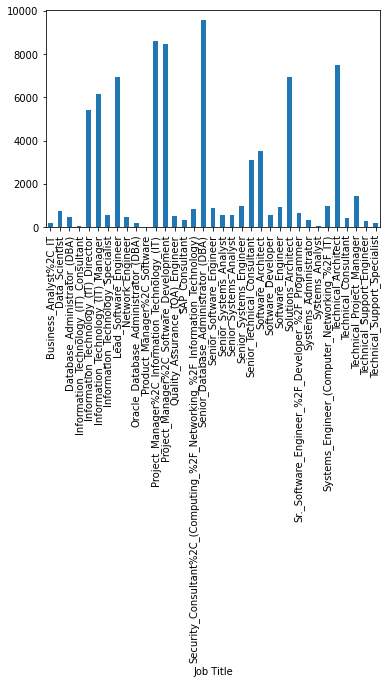

In [66]:
result['average_salary'].plot(kind='bar')